# Predicting time series of MMR rating in dota 2 account

Few words about the task:

1) dd


## Import libs and data

In [1]:
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as scs

from tqdm import tqdm

import numpy as np
from sklearn.metrics import mean_absolute_error

In [33]:
df = pd.read_csv("data", names = ['mmr'])

In [34]:
# had to reverse all rows
df = df[::-1].reset_index()
del df['index']

In [35]:
df

,mmr
0,4290
1,4110
2,4140
3,3990
4,4020
...,...
256,4530
257,4620
258,4500
259,4530


## Visualisation

In [6]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

plotly_df(df, title = "Mmr")

Here we can see how the rating touches the lower limit:

    4400 at points 110-130 and 160-190
    
    4200 at 190-205 and 220-230

And the upper limit:

    4600 at points 130-160, 210-220 and 245-255

## Еconometric method

In [9]:
def plotMovingAverage(series, n):

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(df[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

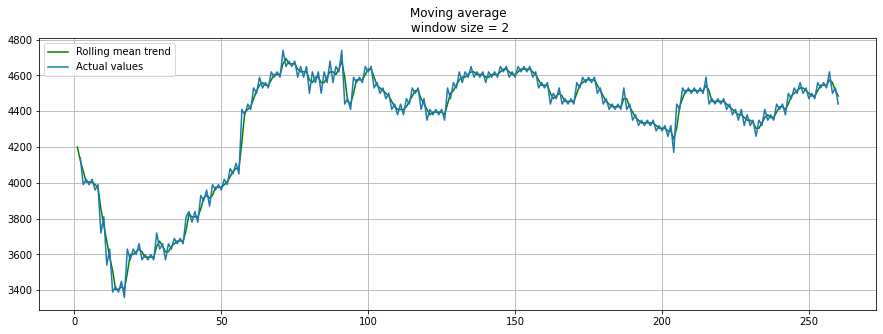

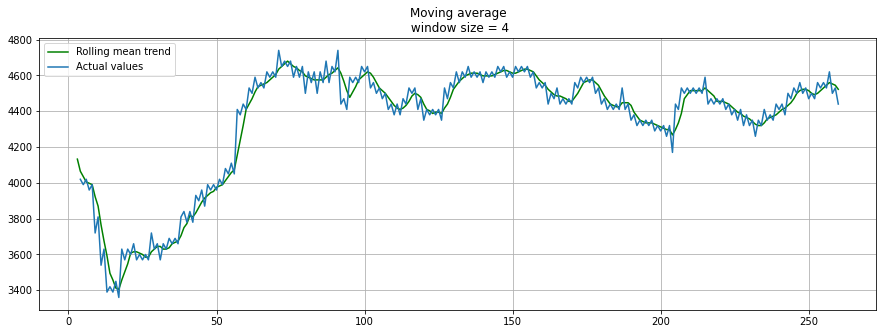

In [10]:
plotMovingAverage(df, 2)
plotMovingAverage(df, 2*2)

Критерий Дики-Фуллера: p=0.141634


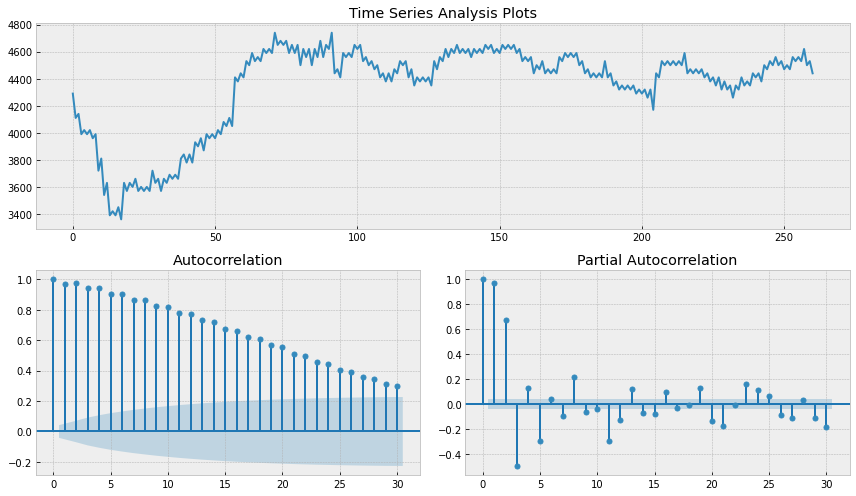

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Adfuller criteria: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df.mmr, lags=30)

In [12]:
data = df1.copy()
data['mmr_box'], lmbda = scs.boxcox(data.mmr)

Критерий Дики-Фуллера: p=0.000175


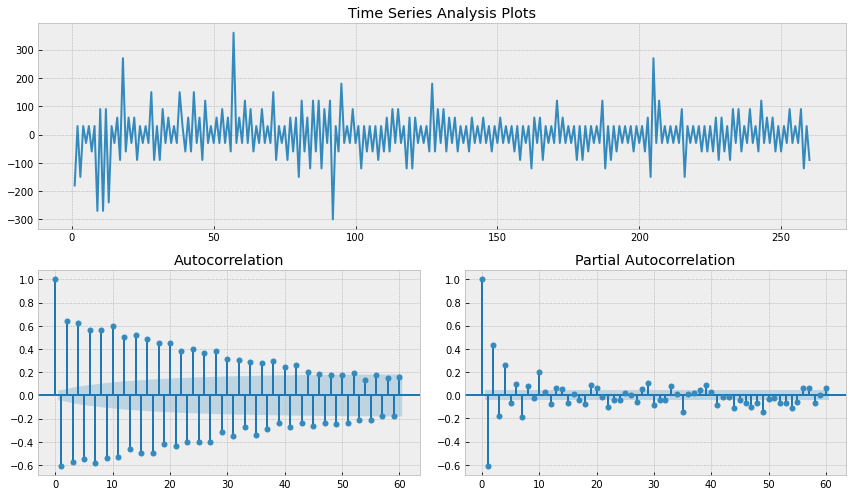

In [14]:
tsplot(data.mmr_box[n:], lags=60)

Критерий Дики-Фуллера: p=0.000000


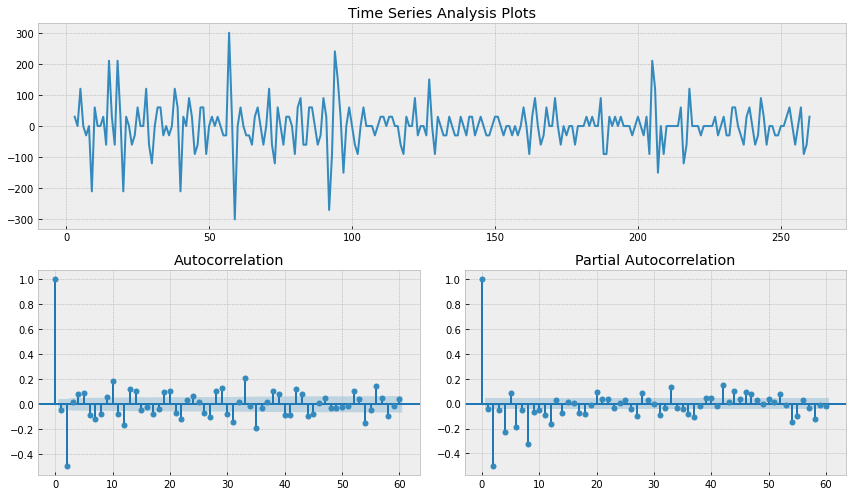

In [13]:
n = 1
s = 2
data['mmr_box'] = data.mmr - data.mmr.shift(n)
data['mmr_box_season'] = data['mmr_box'].diff(s).dropna()
tsplot(data.mmr_box_season[n+s:], lags=60)

c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



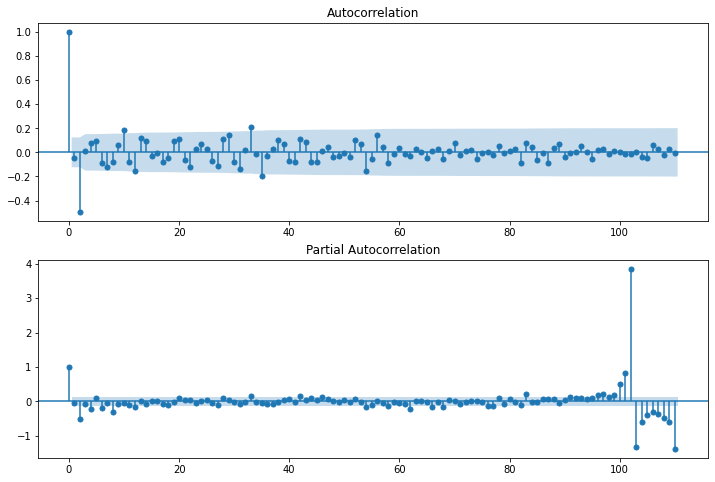

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.mmr_box_season[n+s:].values.squeeze(), lags=110, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.mmr_box_season[n+s:], lags=110, ax=ax2)

In [15]:
ps = range(3, -1, -1)
d=1
qs = range(3, -1, -1)
Ps = range(4, -1, -1)
D=1
Qs = range(2, -1, -1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

240

In [20]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.mmr, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 2)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  6%|▋         | 15/240 [00:00<00:02, 76.13it/s]

wrong parameters: (3, 3, 4, 2)
wrong parameters: (3, 3, 4, 1)
wrong parameters: (3, 3, 4, 0)
wrong parameters: (3, 3, 3, 2)
wrong parameters: (3, 3, 3, 1)
wrong parameters: (3, 3, 3, 0)
wrong parameters: (3, 3, 2, 2)
wrong parameters: (3, 3, 2, 1)
wrong parameters: (3, 3, 2, 0)
wrong parameters: (3, 3, 1, 2)
wrong parameters: (3, 3, 1, 1)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 0, 2)
wrong parameters: (3, 3, 0, 1)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 12%|█▎        | 30/240 [00:00<00:02, 83.39it/s]

wrong parameters: (3, 2, 4, 2)
wrong parameters: (3, 2, 4, 1)
wrong parameters: (3, 2, 4, 0)
wrong parameters: (3, 2, 3, 2)
wrong parameters: (3, 2, 3, 1)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 2, 2)
wrong parameters: (3, 2, 2, 1)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 1, 2)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 1, 4, 2)
wrong parameters: (3, 1, 4, 1)
wrong parameters: (3, 1, 4, 0)
wrong parameters: (3, 1, 3, 2)
wrong parameters: (3, 1, 3, 1)
wrong parameters: (3, 1, 3, 0)
wrong parameters: (3, 1, 2, 2)
wrong parameters: (3, 1, 2, 1)
wrong parameters: (3, 1, 2, 0)
wrong parameters: (3, 1, 1, 2)
wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 1, 1, 0)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 24%|██▍       | 58/240 [00:01<00:04, 37.54it/s]

wrong parameters: (3, 0, 4, 2)
wrong parameters: (3, 0, 4, 1)
wrong parameters: (3, 0, 4, 0)
wrong parameters: (3, 0, 3, 2)
wrong parameters: (3, 0, 3, 1)
wrong parameters: (3, 0, 3, 0)
wrong parameters: (3, 0, 2, 2)
wrong parameters: (3, 0, 2, 1)
wrong parameters: (3, 0, 2, 0)
wrong parameters: (3, 0, 1, 2)
wrong parameters: (3, 0, 1, 1)
wrong parameters: (3, 0, 1, 0)


 31%|███▏      | 75/240 [00:01<00:03, 49.80it/s]

wrong parameters: (2, 3, 4, 2)
wrong parameters: (2, 3, 4, 1)
wrong parameters: (2, 3, 4, 0)
wrong parameters: (2, 3, 3, 2)
wrong parameters: (2, 3, 3, 1)
wrong parameters: (2, 3, 3, 0)
wrong parameters: (2, 3, 2, 2)
wrong parameters: (2, 3, 2, 1)
wrong parameters: (2, 3, 2, 0)
wrong parameters: (2, 3, 1, 2)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 0, 2)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 2, 4, 2)
wrong parameters: (2, 2, 4, 1)
wrong parameters: (2, 2, 4, 0)
wrong parameters: (2, 2, 3, 2)
wrong parameters: (2, 2, 3, 1)
wrong parameters: (2, 2, 3, 0)
wrong parameters: (2, 2, 2, 2)
wrong parameters: (2, 2, 2, 1)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 0, 2)
wrong parameters: (2, 2, 0, 1)


 38%|███▊      | 90/240 [00:01<00:02, 68.17it/s]

wrong parameters: (2, 1, 4, 2)
wrong parameters: (2, 1, 4, 1)
wrong parameters: (2, 1, 4, 0)
wrong parameters: (2, 1, 3, 2)
wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 0)
wrong parameters: (2, 1, 2, 2)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 1, 2)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 0)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 49%|████▉     | 118/240 [00:02<00:02, 46.12it/s]

wrong parameters: (2, 0, 4, 2)
wrong parameters: (2, 0, 4, 1)
wrong parameters: (2, 0, 4, 0)
wrong parameters: (2, 0, 3, 2)
wrong parameters: (2, 0, 3, 1)
wrong parameters: (2, 0, 3, 0)
wrong parameters: (2, 0, 2, 2)
wrong parameters: (2, 0, 2, 1)
wrong parameters: (2, 0, 2, 0)
wrong parameters: (2, 0, 1, 2)
wrong parameters: (2, 0, 1, 1)
wrong parameters: (2, 0, 1, 0)
wrong parameters: (1, 3, 4, 2)
wrong parameters: (1, 3, 4, 1)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 52%|█████▏    | 124/240 [00:03<00:04, 26.47it/s]

wrong parameters: (1, 3, 3, 2)
wrong parameters: (1, 3, 3, 1)
wrong parameters: (1, 3, 2, 2)
wrong parameters: (1, 3, 2, 1)


 54%|█████▍    | 129/240 [00:03<00:06, 17.93it/s]

wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 1, 1)


 57%|█████▋    | 136/240 [00:04<00:05, 18.25it/s]

wrong parameters: (1, 3, 0, 2)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 2, 4, 2)
wrong parameters: (1, 2, 4, 1)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 58%|█████▊    | 139/240 [00:04<00:07, 13.67it/s]

wrong parameters: (1, 2, 3, 2)
wrong parameters: (1, 2, 3, 1)


 60%|██████    | 144/240 [00:04<00:06, 13.89it/s]

wrong parameters: (1, 2, 2, 2)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 1, 1)


 61%|██████▏   | 147/240 [00:04<00:05, 16.01it/s]

wrong parameters: (1, 2, 0, 2)
wrong parameters: (1, 2, 0, 1)


c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 64%|██████▍   | 153/240 [00:06<00:14,  6.16it/s]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 66%|██████▋   | 159/240 [00:08<00:20,  3.87it/s]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 75%|███████▍  | 179/240 [00:11<00:06,  9.38it/s]

wrong parameters: (0, 3, 4, 2)
wrong parameters: (0, 3, 4, 1)


 78%|███████▊  | 186/240 [00:12<00:04, 13.32it/s]

wrong parameters: (0, 3, 3, 2)
wrong parameters: (0, 3, 3, 1)
wrong parameters: (0, 3, 2, 2)
wrong parameters: (0, 3, 2, 1)


 80%|████████  | 192/240 [00:12<00:02, 16.96it/s]

wrong parameters: (0, 3, 1, 2)
wrong parameters: (0, 3, 1, 1)
wrong parameters: (0, 3, 0, 2)
wrong parameters: (0, 3, 0, 1)
wrong parameters: (0, 2, 4, 2)
wrong parameters: (0, 2, 4, 1)


 84%|████████▍ | 201/240 [00:13<00:02, 18.19it/s]

wrong parameters: (0, 2, 3, 2)
wrong parameters: (0, 2, 3, 1)
wrong parameters: (0, 2, 2, 2)
wrong parameters: (0, 2, 2, 1)


 88%|████████▊ | 210/240 [00:13<00:01, 25.16it/s]

wrong parameters: (0, 2, 1, 2)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 0, 2)
wrong parameters: (0, 2, 0, 1)


100%|██████████| 240/240 [00:17<00:00, 14.11it/s]

      parameters          aic
68  (0, 1, 4, 0)  1115.000825
43  (1, 0, 4, 0)  1115.016596
65  (0, 2, 0, 0)  1115.164829
83  (0, 0, 4, 0)  1115.636624
94  (0, 0, 0, 1)  1115.779014
Wall time: 17 s


In [16]:
best_model = sm.tsa.statespace.SARIMAX(data.mmr, order=(0, d, 1), 
                                        seasonal_order=(4, D, 0, 2)).fit(disp=-1)
print(best_model.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                                mmr   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(4, 1, [], 2)   Log Likelihood                -551.500
Date:                            Mon, 24 May 2021   AIC                           1115.001
Time:                                    08:49:52   BIC                           1130.449
Sample:                                         0   HQIC                          1121.247
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1711      0.102     -1.672      0.094      -0.372       0.029
ar.S.L2       -0.7064      0.110   

Критерий Дики-Фуллера: p=0.000000


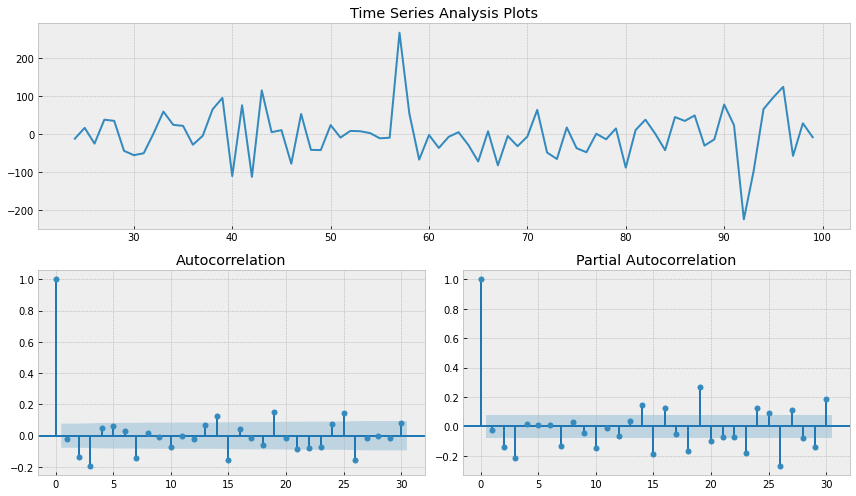

In [17]:
tsplot(best_model.resid[24:], lags=30)

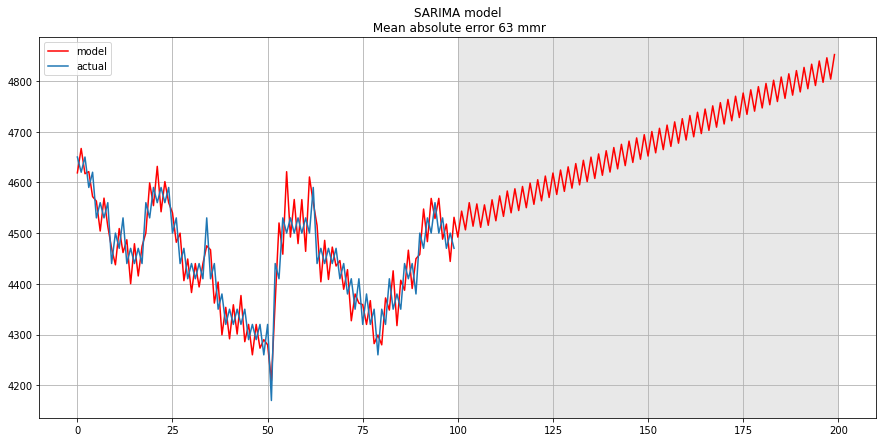

In [16]:
vse = 253
fore = 100
old = 100

best_model = sm.tsa.statespace.SARIMAX(df1.mmr, order=(0, d, 0), 
                                        seasonal_order=(4, D, 0, 2)).fit(disp=-1)

df1["arima_model"] = best_model.fittedvalues
forecast = best_model.predict(start = vse, end = vse+fore)
forecast = df1.arima_model.append(forecast).values[-(old + fore):]
actual = df1.mmr.values[-old:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} mmr".format(round(mean_absolute_error(df1.dropna().mmr, df1.dropna().arima_model))))
plt.plot(actual, label="actual")
#plt.plot(act_val, label="act_val")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [20]:
import pandas as pd
df = pd.read_csv("data", names = ['mmr'])
df1 = df[::-1].reset_index()
del df1['index']
df1 = df[:233].reset_index()
del df1['index']
df1

,mmr
0,4440
1,4530
2,4500
3,4620
4,4530
...,...
228,3660
229,3570
230,3660
231,3630


Критерий Дики-Фуллера: p=0.145149


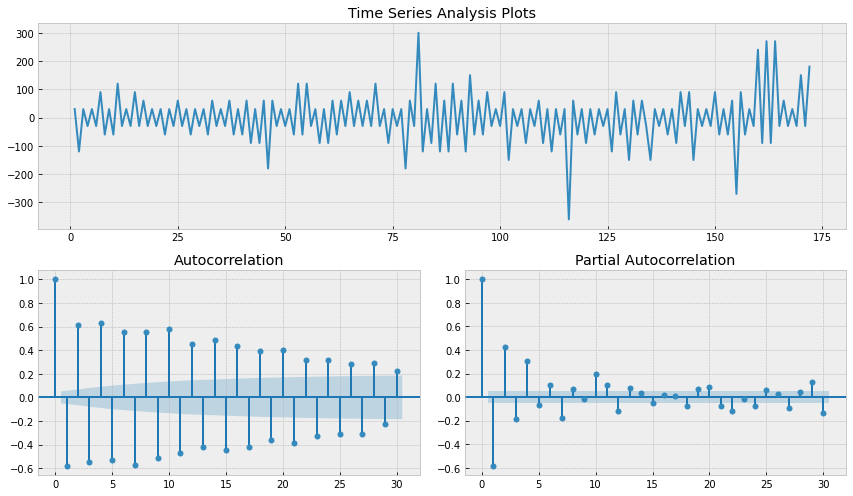

In [95]:
win = df1.mmr.diff(periods=1).dropna()
tsplot(win, lags=30)

Критерий Дики-Фуллера: p=0.000000


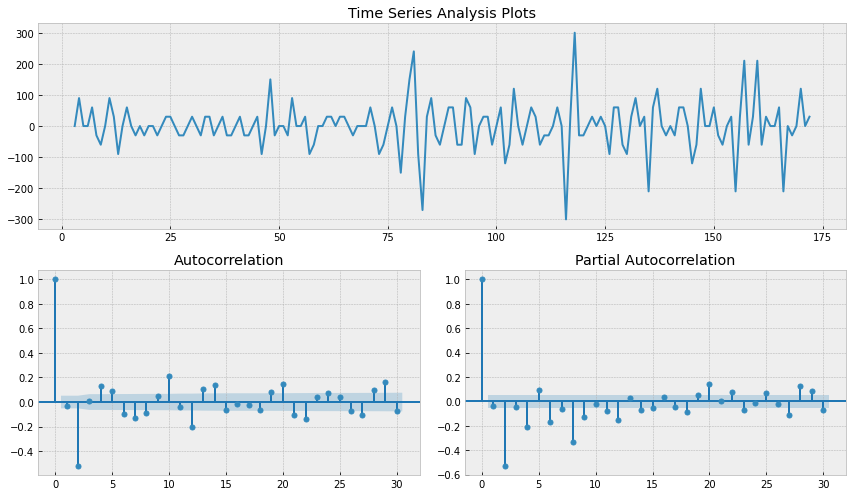

In [96]:
win_s = win.diff(2).dropna()
tsplot(win_s, lags=30)

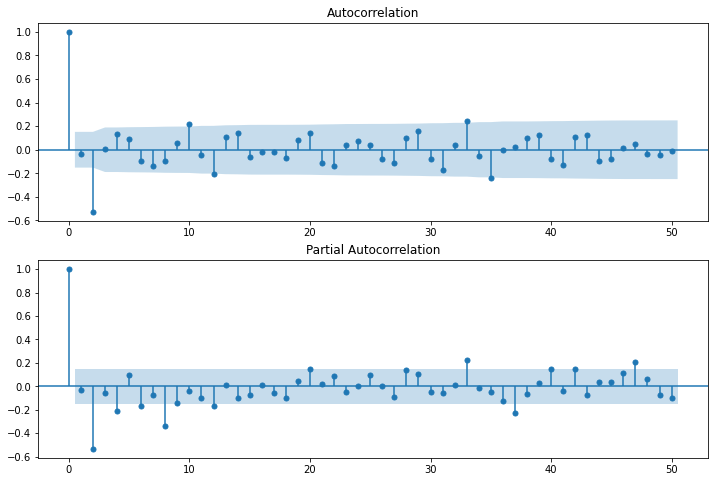

In [97]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(win_s[n+s:].values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(win_s[n+s:], lags=50, ax=ax2)

In [16]:
ps = range(0, -1, -1)
d=1
qs = range(6, 1, -1)
Ps = range(8, 4, -1)
D=1
Qs = range(0, -1, -1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [114]:
%%time
results = []
best_aic = float("inf")
from tqdm import tqdm

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df1.mmr, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 2)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(20))

  0%|          | 0/20 [00:00<?, ?it/s]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  5%|▌         | 1/20 [00:01<00:30,  1.59s/it]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 10%|█         | 2/20 [00:02<00:24,  1.38s/it]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 25%|██▌       | 5/20 [00:05<00:15,  1.05s/it]c:\apps\projects\analysiswinrate_timerows\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 35%|███▌      | 7/20 [00:07<00:11,  1.16it/s]c:\apps\projects\analysisw

      parameters          aic
14  (0, 1, 6, 0)  1879.354356
11  (0, 2, 5, 0)  1879.959893
15  (0, 1, 5, 0)  1880.022059
18  (0, 0, 6, 0)  1880.454405
10  (0, 2, 6, 0)  1880.545815
19  (0, 0, 5, 0)  1880.722075
13  (0, 1, 7, 0)  1880.824661
1   (0, 4, 7, 0)  1881.180533
7   (0, 3, 5, 0)  1881.189828
17  (0, 0, 7, 0)  1881.902139
9   (0, 2, 7, 0)  1882.445825
6   (0, 3, 6, 0)  1882.543357
12  (0, 1, 8, 0)  1882.614361
3   (0, 4, 5, 0)  1882.906382
5   (0, 3, 7, 0)  1883.433641
16  (0, 0, 8, 0)  1883.483354
8   (0, 2, 8, 0)  1883.511968
2   (0, 4, 6, 0)  1884.498439
0   (0, 4, 8, 0)  1884.690477
4   (0, 3, 8, 0)  1884.761901
Wall time: 12.5 s


In [81]:
print(result_table.sort_values(by = 'aic', ascending=True).head(30))

       parameters          aic
169  (0, 0, 6, 2)    35.992445
78   (1, 0, 6, 3)  2510.641362
132  (0, 1, 6, 3)  2511.309034
53   (1, 1, 4, 0)  2511.652507
172  (0, 0, 5, 3)  2512.512009
135  (0, 1, 6, 0)  2513.563128
106  (0, 2, 5, 0)  2513.611047
81   (1, 0, 6, 0)  2513.645675
88   (1, 0, 4, 1)  2513.731667
107  (0, 2, 4, 0)  2513.738401
142  (0, 1, 4, 1)  2513.830162
51   (1, 1, 4, 2)  2514.109710
67   (1, 0, 9, 2)  2514.194582
16   (1, 2, 5, 0)  2514.266052
121  (0, 1, 9, 2)  2514.488101
143  (0, 1, 4, 0)  2514.500268
105  (0, 2, 6, 0)  2514.524143
89   (1, 0, 4, 0)  2514.634306
133  (0, 1, 6, 2)  2514.714261
131  (0, 1, 7, 0)  2514.871411
77   (1, 0, 7, 0)  2514.879307
45   (1, 1, 6, 0)  2514.879464
52   (1, 1, 4, 1)  2514.911456
49   (1, 1, 5, 0)  2514.954604
17   (1, 2, 4, 0)  2515.357875
42   (1, 1, 6, 3)  2515.374949
98   (0, 3, 4, 0)  2515.390149
140  (0, 1, 4, 3)  2515.406912
130  (0, 1, 7, 1)  2515.677338
97   (0, 3, 5, 0)  2515.679109


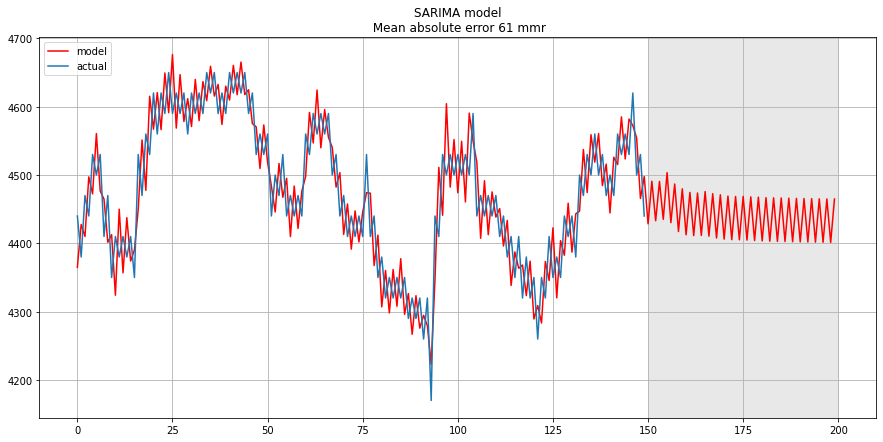

In [31]:
vse = 261 #- 60
fore = 50
old = 150

best_model = sm.tsa.statespace.SARIMAX(df1.mmr[:vse], order=(0, d, 2), 
                                        seasonal_order=(5, D, 0, 2)).fit(disp=-1)

df1["arima_model"] = best_model.fittedvalues
forecast = best_model.predict(start = vse, end = vse+fore)
forecast = df1.arima_model.append(forecast).values[-(old + fore):]
actual = df1.mmr.values[-old:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} mmr".format(round(mean_absolute_error(df1.dropna().mmr, df1.dropna().arima_model))))
plt.plot(actual, label="actual")
#plt.plot(act_val, label="act_val")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [152]:
df = pd.read_csv("data", names = ['mmr'])
df1 = df[::-1].reset_index()
del df1['index']
df1 = df[60:].reset_index()
del df1['index']
df1

,mmr
0,4530
1,4560
2,4440
3,4470
4,4440
...,...
168,4020
169,3990
170,4140
171,4110


## Demonstration examples of decline and growth

Growth after reaching the lower limit of 3400 on June, 2020
![alt text](growth.jpg "Title")

Falling after reaching the upper limit of 4600 on May 20, 2021
![alt text](falling.jpg "Title")

 Main conclusions: 
 
 1) the ideal model is 0520 - as it is the only one that smoothes. There are also 0350 and 0370, but they are much inferior
 
 2) The two graphs above reflect the upper and lower threshold. Top 4590-4650. Bottom 4200-4260. The game keeps me within those limits.
 
 3) Big outliers - lose-streaks or win-streaks - mean how hard you touch the boundary and the harder you get thrown off. 